## 1. Project Setup

### 1.1. Import Libraries

In [ ]:
# Core
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & encoding
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Feature selection
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Imbalance
from imblearn.over_sampling import SMOTE

# Models (same as you already use)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    classification_report
)

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score


# Hyperparameter search utilities
from itertools import product

pd.set_option("display.max_columns", 100)


### 1.2. Import dataset

We load the original HR Attrition dataset and inspect its basic structure:
- shape (rows, columns)
- first 5 records
- data types
- missing values
- distribution of the target variable

Dataset shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel 

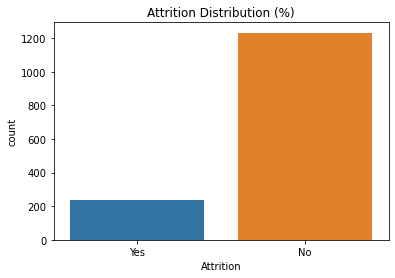

In [32]:
df_raw = pd.read_csv("../dados/HR_Attrition_Dataset.csv")

print("Dataset shape:", df_raw.shape)
display(df_raw.head())

print("\nDataset info:")
print(df_raw.info())

print("\nAttrition distribution:")
print(df_raw["Attrition"].value_counts(normalize=True).mul(100).round(2))

sns.countplot(data=df_raw, x="Attrition")
plt.title("Attrition Distribution (%)")
plt.show()


## 2. Data Cleaning & Basic Transformations

### 2.1 Drop Irrelevant Columns and Prepare Target

- Drop columns that are constant or pure identifiers:
  - EmployeeCount (always 1)
  - StandardHours (always 8)
  - Over18 (always "Y")
  - EmployeeNumber (identifier, not a real feature)
- Convert:
  - Attrition from "Yes"/"No" to 1/0
  - OverTime from "Yes"/"No" to 1/0

Shape after dropping irrelevant columns: (1470, 31)
Columns now:
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Unique values after conversion:
Attrition: [1 0]
OverTime: [1 0]

New Attrition distribution (%):
0    83.88
1    16.12
Name: Attrition, dtype: float64


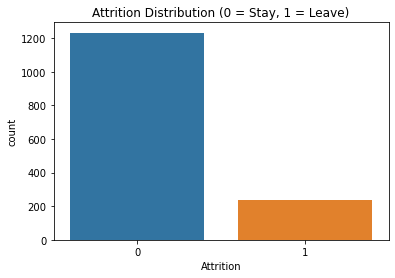

In [33]:
df = df_raw.copy()

# 1) Drop irrelevant / non-informative columns
cols_to_drop = ["EmployeeCount", "StandardHours", "Over18", "EmployeeNumber"]
df = df.drop(columns=cols_to_drop)

print("Shape after dropping irrelevant columns:", df.shape)
print("Columns now:")
print(df.columns.tolist())

# 2) Convert Attrition to binary (target)
df["Attrition"] = df["Attrition"].map({"No": 0, "Yes": 1})

# 3) Convert OverTime to binary
df["OverTime"] = df["OverTime"].map({"No": 0, "Yes": 1})

print("\nUnique values after conversion:")
print("Attrition:", df["Attrition"].unique())
print("OverTime:", df["OverTime"].unique())

# Quick check of target distribution again
print("\nNew Attrition distribution (%):")
print(df["Attrition"].value_counts(normalize=True).mul(100).round(2))

sns.countplot(data=df, x="Attrition")
plt.title("Attrition Distribution (0 = Stay, 1 = Leave)")
plt.show()


## 3. Feature Engineering

We create new meaningful features that capture tenure dynamics and interactions:

- **YearsInRoleRatio**: proportion of tenure spent in current role  
- **YearsWithMgrRatio**: proportion of tenure spent with current manager  
- **OverTime_x_JobSat**: interaction between overtime and job satisfaction  
- **ShortTenure**: flag for employees with ≤ 1 year at the company
- **IncomeVsLevelMedian**: employee income relative to the median income of their job level  

In [34]:
df_fe = df.copy()

# Avoid division by zero
df_fe["YearsAtCompany"] = df_fe["YearsAtCompany"].replace(0, 1)

# 1) Ratio features
df_fe["YearsInRoleRatio"] = df_fe["YearsInCurrentRole"] / df_fe["YearsAtCompany"]
df_fe["YearsWithMgrRatio"] = df_fe["YearsWithCurrManager"] / df_fe["YearsAtCompany"]

# 2) Interaction feature
df_fe["OverTime_x_JobSat"] = df_fe["OverTime"] * df_fe["JobSatisfaction"]

# 3) Short tenure flag
df_fe["ShortTenure"] = (df_fe["YearsAtCompany"] <= 1).astype(int)

# 4) NEW: Income vs JobLevel median income
joblevel_median_income = df_fe.groupby("JobLevel")["MonthlyIncome"].transform("median")
df_fe["IncomeVsLevelMedian"] = df_fe["MonthlyIncome"] / joblevel_median_income

print("New shape:", df_fe.shape)

# Show first rows
display(df_fe[[
    "YearsInRoleRatio",
    "YearsWithMgrRatio",
    "OverTime_x_JobSat",
    "ShortTenure",
    "IncomeVsLevelMedian",
    "JobLevel",
    "MonthlyIncome"
]].head())


New shape: (1470, 36)


,YearsInRoleRatio,YearsWithMgrRatio,OverTime_x_JobSat,ShortTenure,IncomeVsLevelMedian,JobLevel,MonthlyIncome
0,0.666667,0.833333,4,0,1.122285,2,5993
1,0.700000,0.700000,0,0,0.960674,2,5130
2,0.000000,0.000000,3,1,0.782772,1,2090
3,0.875000,0.000000,3,0,1.089513,1,2909
4,1.000000,1.000000,0,0,1.298876,1,3468


In [35]:
df_fe.shape

(1470, 36)

## 4. Feature Grouping

We categorize all variables into the correct preprocessing groups:

- **Numeric continuous**: raw numeric variables  
- **Ordinal**: encoded as integers with ordered meaning  
- **Binary**: 0/1 variables  
- **Categorical nominal**: to be one-hot encoded  
- **Engineered features**: new numeric variables created in Step 3  

These groups are essential for a correct preprocessing pipeline.

In [36]:
# All numeric features (continuous + ordinal + engineered)
numeric_features = [
    "Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome",
    "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears",
    "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole",
    "YearsSinceLastPromotion", "YearsWithCurrManager",
    
    # Ordinal features (kept as numeric)
    "Education", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel",
    "JobSatisfaction", "PerformanceRating", "RelationshipSatisfaction",
    "WorkLifeBalance", "StockOptionLevel",
    
    # Engineered numeric features
    "YearsInRoleRatio", "YearsWithMgrRatio", "OverTime_x_JobSat",
    "IncomeVsLevelMedian"
]

# Binary features (0/1)
binary_features = ["OverTime", "ShortTenure"]

# Categorical nominal → one-hot encoded
categorical_features = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus"
]

print("Numeric features:", len(numeric_features))
print("Binary features:", len(binary_features))
print("Categorical features:", len(categorical_features))
print("Total features accounted for:", 
      len(numeric_features) + len(binary_features) + len(categorical_features))


Numeric features: 27
Binary features: 2
Categorical features: 6
Total features accounted for: 35


## 5. Train/Validation/Test Split

- First: 80% train+val / 20% test  
- Second: split the 80% into 60% train and 20% validation  

Using `stratify=y` ensures the class imbalance is preserved in all splits.


In [37]:
# 1) Separate features and target
X = df_fe.drop("Attrition", axis=1)
y = df_fe["Attrition"]

print("Original shapes:", X.shape, y.shape)

# 2) First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 3) Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Show sizes
print("\n📊 Dataset Split Sizes:")
print("Train:", X_train.shape[0])
print("Validation:", X_val.shape[0])
print("Test:", X_test.shape[0])

# Show percentages
total = len(df_fe)
print("\nPercentages:")
print(f"Train: {X_train.shape[0] / total * 100:.1f}%")
print(f"Validation: {X_val.shape[0] / total * 100:.1f}%")
print(f"Test: {X_test.shape[0] / total * 100:.1f}%")

# Confirm stratified balance
print("\n🔍 Class balance check:")
print("Train:\n", y_train.value_counts(normalize=True))
print("\nValidation:\n", y_val.value_counts(normalize=True))
print("\nTest:\n", y_test.value_counts(normalize=True))


Original shapes: (1470, 35) (1470,)

📊 Dataset Split Sizes:
Train: 882
Validation: 294
Test: 294

Percentages:
Train: 60.0%
Validation: 20.0%
Test: 20.0%

🔍 Class balance check:
Train:
 0    0.837868
1    0.162132
Name: Attrition, dtype: float64

Validation:
 0    0.840136
1    0.159864
Name: Attrition, dtype: float64

Test:
 0    0.840136
1    0.159864
Name: Attrition, dtype: float64


## 6. Preprocessing Pipeline

We apply a ColumnTransformer with:
- passthrough for numerical (continuous + ordinal + binary)
- OneHotEncoder for true categorical features

The encoder is **fitted only on the training set** to avoid data leakage.



### 6.1.

In [38]:
# Combine numeric + binary for passthrough
numeric_and_binary = numeric_features + binary_features

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_and_binary),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ]
)

# Fit on training data only
X_train_encoded = preprocessor.fit_transform(X_train)

# Transform validation and test
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)

print("Encoded Train shape:", X_train_encoded.shape)
print("Encoded Validation shape:", X_val_encoded.shape)
print("Encoded Test shape:", X_test_encoded.shape)


Encoded Train shape: (882, 49)
Encoded Validation shape: (294, 49)
Encoded Test shape: (294, 49)


### 6.2. OHE feature names

In [39]:
# Get OHE feature names
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Final encoded feature list
encoded_feature_names = numeric_and_binary + list(ohe_feature_names)

print("Total encoded features:", len(encoded_feature_names))
encoded_feature_names[:15]


Total encoded features: 49


['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Education']

### 6.3 Inspect Encoded Training Dataset


We inspect the feature matrix after preprocessing to confirm:
- All features are numeric
- One-hot encoding worked correctly
- No target leakage
- No missing values
- No constant columns

In [40]:
# Convert encoded arrays back into DataFrame for inspection
X_train_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names)
X_val_df   = pd.DataFrame(X_val_encoded,   columns=encoded_feature_names)
X_test_df  = pd.DataFrame(X_test_encoded,  columns=encoded_feature_names)

# Show first rows
display(X_train_df.head())

print("\nINFO:")
print(X_train_df.info())

print("\nDescribe:")
display(X_train_df.describe().T.head(10))  # first 10 rows of describe

print("\nCheck missing values:")
print(X_train_df.isna().sum().sum())

print("\nCheck for constant columns:")
constant_cols = [col for col in X_train_df.columns if X_train_df[col].nunique() == 1]
constant_cols


,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance,StockOptionLevel,YearsInRoleRatio,YearsWithMgrRatio,OverTime_x_JobSat,IncomeVsLevelMedian,OverTime,ShortTenure,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,32.0,1045.0,4.0,32.0,10400.0,25812.0,1.0,11.0,14.0,2.0,14.0,8.0,9.0,8.0,4.0,4.0,1.0,3.0,4.0,3.0,3.0,2.0,0.0,0.571429,0.571429,0.0,1.042084,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,46.0,669.0,9.0,64.0,9619.0,13596.0,1.0,16.0,9.0,3.0,9.0,8.0,4.0,7.0,2.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,0.0,0.888889,0.777778,0.0,0.963828,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,40.0,902.0,26.0,92.0,4422.0,21203.0,3.0,13.0,16.0,3.0,1.0,1.0,0.0,0.0,2.0,3.0,2.0,2.0,4.0,3.0,4.0,1.0,1.0,1.000000,0.000000,4.0,0.828090,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,38.0,1153.0,6.0,40.0,3702.0,16376.0,1.0,11.0,5.0,3.0,5.0,4.0,0.0,4.0,2.0,4.0,2.0,1.0,3.0,3.0,2.0,3.0,1.0,0.800000,0.800000,0.0,1.386517,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,38.0,322.0,7.0,44.0,5605.0,19191.0,1.0,24.0,8.0,3.0,8.0,0.0,7.0,7.0,2.0,1.0,4.0,2.0,1.0,4.0,3.0,3.0,1.0,0.000000,0.875000,1.0,1.049625,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                882 non-null    float64
 1   DailyRate                          882 non-null    float64
 2   DistanceFromHome                   882 non-null    float64
 3   HourlyRate                         882 non-null    float64
 4   MonthlyIncome                      882 non-null    float64
 5   MonthlyRate                        882 non-null    float64
 6   NumCompaniesWorked                 882 non-null    float64
 7   PercentSalaryHike                  882 non-null    float64
 8   TotalWorkingYears                  882 non-null    float64
 9   TrainingTimesLastYear              882 non-null    float64
 10  YearsAtCompany                     882 non-null    float64
 11  YearsInCurrentRole                 882 non-null    

,count,mean,std,min,25%,50%,75%,max
Age,882.0,37.019274,9.107547,18.0,30.00,36.0,43.00,60.0
DailyRate,882.0,807.587302,400.181306,103.0,464.25,810.0,1153.75,1495.0
DistanceFromHome,882.0,9.274376,8.135180,1.0,2.00,7.0,14.00,29.0
HourlyRate,882.0,65.502268,20.192392,30.0,48.00,66.0,82.75,100.0
MonthlyIncome,882.0,6590.778912,4688.045182,1009.0,2927.50,5068.5,8458.50,19973.0
MonthlyRate,882.0,14347.916100,7175.706151,2094.0,8092.00,14223.5,20733.00,26999.0
NumCompaniesWorked,882.0,2.729025,2.484969,0.0,1.00,2.0,4.00,9.0
PercentSalaryHike,882.0,15.180272,3.648323,11.0,12.00,14.0,18.00,25.0
TotalWorkingYears,882.0,11.436508,7.804576,0.0,6.00,10.0,15.00,40.0
TrainingTimesLastYear,882.0,2.778912,1.256939,0.0,2.00,3.0,3.00,6.0



Check missing values:
0

Check for constant columns:


[]

## 7. Feature Selection

In this section we reduce the number of input features to keep only those that are consistently useful for predicting employee attrition.

Working with many features can:
- increase model complexity and risk of overfitting,
- make models slower and harder to interpret,
- introduce noise that does not help predictions.

To address this, we apply several feature selection methods **only on the training set** to avoid any information leakage from the validation or test sets.

---

### Methods overview

We use four complementary methods:

1. **Spearman correlation (numeric features only)**  
   - Non-parametric correlation between each numeric feature and the target.  
   - Captures monotonic (not necessarily linear) relationships.  
   - We consider a feature relevant if:  
     - |correlation| > 0.10 and  
     - p-value < 0.05.

2. **Chi-squared test (categorical one-hot features only)**  
   - Tests statistical dependence between each categorical dummy variable and the target.  
   - Requires non-negative values (one-hot encoded 0/1 variables satisfy this).  
   - We keep features with p-value < 0.05.

3. **Mutual Information (all features)**  
   - Measures how much knowing a feature reduces uncertainty about the target.  
   - Does not assume linearity and can capture complex relationships.  
   - We keep the **top 30%** features with the highest MI scores.

4. **Random Forest feature importance (all features)**  
   - Tree-based model that can capture non-linear relationships and interactions.  
   - We compute feature importances from a Random Forest classifier.  
   - We keep the **top 30%** features with the highest importance.

---

### Voting strategy

Each method “votes” for a feature when it considers that feature relevant.

We then apply a **conservative voting rule**:

> A feature is selected if it is marked as relevant by **at least 2 methods**.

This rule:
- reduces noisy or weak features,
- keeps variables that are consistently useful,
- improves interpretability and robustness.

The final result is a smaller, cleaner feature set that we will use to build an alternative “selected features” dataset for comparison with the full feature set.



In [42]:
all_features = X_train_df.columns.tolist()

# Prepare feature groups for FS
numeric_fs = numeric_features + binary_features
categorical_ohe_fs = [f for f in all_features if f not in numeric_fs]

print(f"Total encoded features: {len(all_features)}")
print(f"Numeric+Binary:         {len(numeric_fs)}")
print(f"Categorical OHE:        {len(categorical_ohe_fs)}")

# ====================================================
# 1) Spearman (numeric only)
# ====================================================
from scipy.stats import spearmanr

spearman_results = {}
for feature in numeric_fs:
    corr, p = spearmanr(X_train_df[feature], y_train)
    spearman_results[feature] = (corr, p)

spearman_selected = [
    f for f, (corr, p) in spearman_results.items()
    if abs(corr) > 0.10 and p < 0.05
]

print("\nSpearman selected:", len(spearman_selected))

# ====================================================
# 2) Chi-Squared (categorical only)
# ====================================================
from sklearn.feature_selection import chi2, SelectKBest

X_cat = X_train_df[categorical_ohe_fs]

chi_selector = SelectKBest(chi2, k='all')
chi_selector.fit(X_cat, y_train)

chi_pvals = chi_selector.pvalues_
chi_selected = [
    feature for feature, p in zip(categorical_ohe_fs, chi_pvals)
    if p < 0.05
]

print("Chi2 selected:", len(chi_selected))

# ====================================================
# 3) Mutual Information (all features)
# ====================================================
from sklearn.feature_selection import mutual_info_classif
import numpy as np

mi_scores = mutual_info_classif(X_train_df, y_train, random_state=42)
mi_threshold = np.percentile(mi_scores, 70)

mi_selected = [
    f for f, score in zip(all_features, mi_scores)
    if score > mi_threshold
]

print("Mutual Information selected:", len(mi_selected))

# ====================================================
# 4) Random Forest Importance (all features)
# ====================================================
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train)

rf_importances = rf.feature_importances_
rf_threshold = np.percentile(rf_importances, 70)

rf_selected = [
    f for f, score in zip(all_features, rf_importances)
    if score > rf_threshold
]

print("Random Forest selected:", len(rf_selected))

# ====================================================
# Build voting table
# ====================================================
votes = pd.DataFrame(index=all_features)
votes["Spearman"] = votes.index.isin(spearman_selected).astype(int)
votes["Chi2"]      = votes.index.isin(chi_selected).astype(int)
votes["MI"]        = votes.index.isin(mi_selected).astype(int)
votes["RF"]        = votes.index.isin(rf_selected).astype(int)

votes["TotalVotes"] = votes[["Spearman", "Chi2", "MI", "RF"]].sum(axis=1)
votes["Selected"]   = votes["TotalVotes"] >= 2   # RULE: ≥ 2 votes

print("\n\n=== FINAL FEATURE SELECTION TABLE (first 15 rows) ===")
display(votes.head(15))

selected_features = votes[votes["Selected"]].index.tolist()

print("\n===============================")
print("FINAL FEATURE SELECTION SUMMARY")
print("===============================")
print(f"Total features before selection: {len(all_features)}")
print(f"Features selected (≥ 2 votes):   {len(selected_features)}")
print(f"Features removed:                 {len(all_features) - len(selected_features)}")


# ====================================================
# Create reduced datasets (train/val/test)
# ====================================================
X_train_reduced = X_train_df[selected_features].copy()
X_val_reduced   = X_val_df[selected_features].copy()
X_test_reduced  = X_test_df[selected_features].copy()

print("\nReduced dataset shapes:")
print("  X_train_reduced:", X_train_reduced.shape)
print("  X_val_reduced:  ", X_val_reduced.shape)
print("  X_test_reduced: ", X_test_reduced.shape)


# Optional: summary by type
numeric_selected = [f for f in selected_features if f in numeric_fs]
binary_selected  = [f for f in selected_features if f in binary_features]
cat_selected     = [f for f in selected_features if f in categorical_ohe_fs]

print("\nSelected by type:")
print(f"  Numeric: {len(numeric_selected)}")
print(f"  Binary:  {len(binary_selected)}")
print(f"  Categorical OHE: {len(cat_selected)}")

print("\nTop 10 features by votes:")
display(votes.sort_values("TotalVotes", ascending=False).head(10))


Total encoded features: 49
Numeric+Binary:         29
Categorical OHE:        20

Spearman selected: 15
Chi2 selected: 9
Mutual Information selected: 15
Random Forest selected: 15


=== FINAL FEATURE SELECTION TABLE (first 15 rows) ===


,Spearman,Chi2,MI,RF,TotalVotes,Selected
Age,1,0,1,1,3,True
DailyRate,0,0,0,1,1,False
DistanceFromHome,1,0,1,1,3,True
HourlyRate,0,0,0,1,1,False
MonthlyIncome,1,0,1,1,3,True
MonthlyRate,0,0,0,1,1,False
NumCompaniesWorked,0,0,0,1,1,False
PercentSalaryHike,0,0,1,1,2,True
TotalWorkingYears,1,0,1,1,3,True
TrainingTimesLastYear,0,0,0,0,0,False



FINAL FEATURE SELECTION SUMMARY
Total features before selection: 49
Features selected (≥ 2 votes):   15
Features removed:                 34

Reduced dataset shapes:
  X_train_reduced: (882, 15)
  X_val_reduced:   (294, 15)
  X_test_reduced:  (294, 15)

Selected by type:
  Numeric: 13
  Binary:  0
  Categorical OHE: 2

Top 10 features by votes:


,Spearman,Chi2,MI,RF,TotalVotes,Selected
Age,1,0,1,1,3,True
DistanceFromHome,1,0,1,1,3,True
MonthlyIncome,1,0,1,1,3,True
TotalWorkingYears,1,0,1,1,3,True
JobInvolvement,1,0,1,1,3,True
EnvironmentSatisfaction,1,0,0,1,2,True
MaritalStatus_Married,0,1,1,0,2,True
JobRole_Sales Representative,0,1,1,0,2,True
OverTime_x_JobSat,1,0,0,1,2,True
StockOptionLevel,1,0,1,0,2,True


In [43]:
display(votes.sort_values("TotalVotes", ascending=False))


,Spearman,Chi2,MI,RF,TotalVotes,Selected
Age,1,0,1,1,3,True
DistanceFromHome,1,0,1,1,3,True
MonthlyIncome,1,0,1,1,3,True
TotalWorkingYears,1,0,1,1,3,True
JobInvolvement,1,0,1,1,3,True
EnvironmentSatisfaction,1,0,0,1,2,True
MaritalStatus_Married,0,1,1,0,2,True
JobRole_Sales Representative,0,1,1,0,2,True
OverTime_x_JobSat,1,0,0,1,2,True
StockOptionLevel,1,0,1,0,2,True


### 7.2. Results

Feature-Selection Results Overview

The four methods produced a total of **49 encoded features**.  
Using the voting rule (≥ 2 votes), we selected:

- **15 final features**
- **34 removed features**
- **~69% dimensionality reduction**

### **Selected Features Summary**
- **Numeric:** 13  
- **Binary:** 0  
- **Categorical (OHE):** 2  

### **Why these features matter**
The selected predictors align strongly with research in HR analytics:

- **Age, TotalWorkingYears, YearsAtCompany**  
  Reflect career stage and tenure patterns related to turnover.

- **DistanceFromHome**  
  Higher commute burden increases attrition probability.

- **MonthlyIncome, PercentSalaryHike**  
  Compensation dissatisfaction is a strong attrition driver.

- **JobInvolvement, EnvironmentSatisfaction, JobLevel, StockOptionLevel**  
  Capture engagement, stability, career level, and incentives.

- **OverTime_x_JobSat**  
  Important engineered interaction revealing overtime dissatisfaction.

- **YearsInCurrentRole, YearsWithMgrRatio**  
  Capture stagnation and managerial relationship quality.

- **MaritalStatus_Married, JobRole_Sales Representative**  
  Categories empirically associated with lower/higher attrition rates.

### **Interpretation of Voting Changes**
Some features (e.g., OverTime) behaved differently compared to earlier versions because:
- We added new engineered features that compete for importance  
- We changed preprocessing order (splitting first → more realistic variation)  
- Methods like Spearman and MI measure relationships differently  
- One-hot encoding produces category-level importance rather than the original variable  

These fluctuations are normal and indicate a **more reliable, less biased selection**.

### **Conclusion**
This multi-method, voting-based selection provides a stable, interpretable, and compact set of predictors.  
The reduced dataset is now ready for **model training and hyperparameter tuning** in the next section.


## 8. Model Comparison (Full Dataset vs Selected Features)

In this section, we train a set of machine learning models using **two versions** of the dataset:

1. **Full feature set (49 encoded features)**  
2. **Reduced feature set (15 selected features)**  

This dual evaluation helps us understand:

- Whether feature selection improves generalization  
- Which models are robust to irrelevant/noisy features  
- Which models should be prioritized for hyperparameter tuning  

---

### **Models Evaluated**

We use a diverse group of algorithms to cover linear, non-linear, tree-based, distance-based, and boosting approaches:

- Logistic Regression  
- Decision Tree  
- Random Forest  
- Support Vector Machine  
- K-Nearest Neighbors  
- Neural Network (MLP)  
- XGBoost  
- LightGBM  

This variety ensures we capture the best possible model structure for this dataset.

---

### **Evaluation Protocol**

To ensure fair comparison and avoid data leakage:

1. **Train**, **Validation**, and **Test** sets were created before preprocessing.  
2. **SMOTE is applied only to the training set** to address the class imbalance.  
3. **Scaling is fitted on training data only** and applied to validation/test.  
4. Each model is evaluated with:

   - 5-fold cross-validation on the training set  
   - Validation metrics for model selection  
   - Test metrics for unbiased evaluation  

The main evaluation metric is:

- **Weighted F1 Score** (due to class imbalance)

We also report precision, recall, and accuracy for completeness.

---

### **Goals of This Section**

This stage aims to answer:

- Which models perform best overall?
- Does the **reduced feature set** improve or harm performance?
- Which models are stable (similar validation and test scores)?
- Which models show overfitting (high training, low validation)?

---

### **What Happens Next**

At the end of this section, we will:

- Identify the **top 1–2 models** based on:
  - Validation Weighted F1
  - Test Weighted F1
  - Cross-validation stability
  - Generalization gap

Only the best models progress to tuning.

---

### 8.1. Model Evaluation

In [44]:
# =====================================================
# Utility: Scoring function
# =====================================================
def evaluate_predictions(y_true, y_pred, name="Validation"):
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    accuracy = accuracy_score(y_true, y_pred)

    print(f"\n{name} Metrics:")
    print(f"  Weighted F1:  {weighted_f1:.3f}")
    print(f"  Precision:    {precision:.3f}")
    print(f"  Recall:       {recall:.3f}")
    print(f"  Accuracy:     {accuracy:.3f}")

    return weighted_f1, precision, recall, accuracy


# =====================================================
# Core function: Train model with proper workflow
# =====================================================
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test):
    
    # 1) Apply SMOTE only to training
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

    # 2) Scale numeric features — fit only on training
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    # 3) Cross-validation on training
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in skf.split(X_train_scaled, y_train_bal):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
        
        model_cv = model.__class__(**model.get_params())
        model_cv.fit(X_cv_train, y_cv_train)
        preds = model_cv.predict(X_cv_val)
        cv_scores.append(f1_score(y_cv_val, preds, average="weighted"))

    cv_mean = np.mean(cv_scores)

    # 4) Fit final model
    model.fit(X_train_scaled, y_train_bal)

    # 5) Evaluate
    train_preds = model.predict(X_train_scaled)
    val_preds   = model.predict(X_val_scaled)
    test_preds  = model.predict(X_test_scaled)

    train_metrics = evaluate_predictions(y_train_bal, train_preds, "Training")
    val_metrics   = evaluate_predictions(y_val, val_preds, "Validation")
    test_metrics  = evaluate_predictions(y_test, test_preds, "Test")

    return {
        "cv_mean": cv_mean,
        "train": train_metrics,
        "val": val_metrics,
        "test": test_metrics,
    }


# =====================================================
# MODEL DEFINITIONS (aligned with your colleague)
# =====================================================

models = {
    "Logistic Regression": LogisticRegression(
        C=100, solver="lbfgs", max_iter=1000, class_weight="balanced"
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=3, random_state=42, class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced"
    ),
    "Support Vector Machine": SVC(
        probability=True, class_weight="balanced", random_state=42
    ),
    "KNN": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(32,16),
        max_iter=2000,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        random_state=42,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    ),
    "LightGBM": LGBMClassifier(
        random_state=42,
        class_weight="balanced"
    )
}


# =====================================================
# RUN EXPERIMENTS — FULL vs REDUCED FEATURE SET
# =====================================================

results_full = {}
results_reduced = {}

print("\n===============================")
print("TRAINING MODELS — FULL FEATURE SET (49 features)")
print("===============================")

for name, model in models.items():
    print(f"\n▶ Running {name}...")
    results_full[name] = train_and_evaluate(
        model,
        X_train_df, y_train,
        X_val_df, y_val,
        X_test_df, y_test
    )

print("\n===============================")
print("TRAINING MODELS — REDUCED FEATURE SET (15 features)")
print("===============================")

for name, model in models.items():
    print(f"\n▶ Running {name}...")
    results_reduced[name] = train_and_evaluate(
        model,
        X_train_reduced, y_train,
        X_val_reduced, y_val,
        X_test_reduced, y_test
    )

print("\n✅ All models trained successfully!")



TRAINING MODELS — FULL FEATURE SET (49 features)

▶ Running Logistic Regression...


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training Metrics:
  Weighted F1:  0.835
  Precision:    0.836
  Recall:       0.835
  Accuracy:     0.835

Validation Metrics:
  Weighted F1:  0.807
  Precision:    0.853
  Recall:       0.786
  Accuracy:     0.786

Test Metrics:
  Weighted F1:  0.805
  Precision:    0.841
  Recall:       0.786
  Accuracy:     0.786

▶ Running Decision Tree...

Training Metrics:
  Weighted F1:  0.803
  Precision:    0.830
  Recall:       0.806
  Accuracy:     0.806

Validation Metrics:
  Weighted F1:  0.845
  Precision:    0.842
  Recall:       0.861
  Accuracy:     0.861

Test Metrics:
  Weighted F1:  0.849
  Precision:    0.845
  Recall:       0.854
  Accuracy:     0.854

▶ Running Random Forest...


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training Metrics:
  Weighted F1:  1.000
  Precision:    1.000
  Recall:       1.000
  Accuracy:     1.000

Validation Metrics:
  Weighted F1:  0.861
  Precision:    0.884
  Recall:       0.884
  Accuracy:     0.884

Test Metrics:
  Weighted F1:  0.819
  Precision:    0.829
  Recall:       0.854
  Accuracy:     0.854

▶ Running Support Vector Machine...


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training Metrics:
  Weighted F1:  0.968
  Precision:    0.969
  Recall:       0.968
  Accuracy:     0.968

Validation Metrics:
  Weighted F1:  0.857
  Precision:    0.860
  Recall:       0.874
  Accuracy:     0.874

Test Metrics:
  Weighted F1:  0.838
  Precision:    0.834
  Recall:       0.854
  Accuracy:     0.854

▶ Running KNN...

Training Metrics:
  Weighted F1:  0.864
  Precision:    0.894
  Recall:       0.866
  Accuracy:     0.866

Validation Metrics:
  Weighted F1:  0.722
  Precision:    0.831
  Recall:       0.680
  Accuracy:     0.680

Test Metrics:
  Weighted F1:  0.695
  Precision:    0.797
  Recall:       0.650
  Accuracy:     0.650

▶ Running Neural Network...


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training Metrics:
  Weighted F1:  1.000
  Precision:    1.000
  Recall:       1.000
  Accuracy:     1.000

Validation Metrics:
  Weighted F1:  0.848
  Precision:    0.845
  Recall:       0.850
  Accuracy:     0.850

Test Metrics:
  Weighted F1:  0.828
  Precision:    0.827
  Recall:       0.830
  Accuracy:     0.830

▶ Running XGBoost...


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training Metrics:
  Weighted F1:  1.000
  Precision:    1.000
  Recall:       1.000
  Accuracy:     1.000

Validation Metrics:
  Weighted F1:  0.866
  Precision:    0.863
  Recall:       0.874
  Accuracy:     0.874

Test Metrics:
  Weighted F1:  0.825
  Precision:    0.819
  Recall:       0.844
  Accuracy:     0.844

▶ Running LightGBM...
[LightGBM] [Info] Number of positive: 591, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7299
[LightGBM] [Info] Number of data points in the train set: 1182, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 591, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 591, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7448
[LightGBM] [Info] Number of data points in the train set: 1182, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 591, number of negative: 592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7286
[LightGBM] [Info] Number of data points in the train set: 1183, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 592, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7268
[LightGBM] [Info] Number of data points in the train set: 1183, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 739, number of negative: 739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8892
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._valid


Training Metrics:
  Weighted F1:  1.000
  Precision:    1.000
  Recall:       1.000
  Accuracy:     1.000

Validation Metrics:
  Weighted F1:  0.868
  Precision:    0.869
  Recall:       0.881
  Accuracy:     0.881

Test Metrics:
  Weighted F1:  0.820
  Precision:    0.818
  Recall:       0.847
  Accuracy:     0.847

TRAINING MODELS — REDUCED FEATURE SET (15 features)

▶ Running Logistic Regression...

Training Metrics:
  Weighted F1:  0.721
  Precision:    0.721
  Recall:       0.721
  Accuracy:     0.721

Validation Metrics:
  Weighted F1:  0.784
  Precision:    0.837
  Recall:       0.759
  Accuracy:     0.759

Test Metrics:
  Weighted F1:  0.718
  Precision:    0.817
  Recall:       0.677
  Accuracy:     0.677

▶ Running Decision Tree...

Training Metrics:
  Weighted F1:  0.778
  Precision:    0.780
  Recall:       0.779
  Accuracy:     0.779

Validation Metrics:
  Weighted F1:  0.816
  Precision:    0.831
  Recall:       0.806
  Accuracy:     0.806

Test Metrics:
  Weighted F1:  

c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training Metrics:
  Weighted F1:  0.897
  Precision:    0.897
  Recall:       0.897
  Accuracy:     0.897

Validation Metrics:
  Weighted F1:  0.837
  Precision:    0.837
  Recall:       0.837
  Accuracy:     0.837

Test Metrics:
  Weighted F1:  0.793
  Precision:    0.808
  Recall:       0.782
  Accuracy:     0.782

▶ Running KNN...

Training Metrics:
  Weighted F1:  0.898
  Precision:    0.911
  Recall:       0.899
  Accuracy:     0.899


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Validation Metrics:
  Weighted F1:  0.760
  Precision:    0.803
  Recall:       0.735
  Accuracy:     0.735

Test Metrics:
  Weighted F1:  0.757
  Precision:    0.828
  Recall:       0.724
  Accuracy:     0.724

▶ Running Neural Network...


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training Metrics:
  Weighted F1:  0.963
  Precision:    0.964
  Recall:       0.963
  Accuracy:     0.963

Validation Metrics:
  Weighted F1:  0.796
  Precision:    0.809
  Recall:       0.786
  Accuracy:     0.786

Test Metrics:
  Weighted F1:  0.785
  Precision:    0.798
  Recall:       0.776
  Accuracy:     0.776

▶ Running XGBoost...


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training Metrics:
  Weighted F1:  1.000
  Precision:    1.000
  Recall:       1.000
  Accuracy:     1.000

Validation Metrics:
  Weighted F1:  0.845
  Precision:    0.843
  Recall:       0.847
  Accuracy:     0.847

Test Metrics:
  Weighted F1:  0.811
  Precision:    0.807
  Recall:       0.816
  Accuracy:     0.816

▶ Running LightGBM...
[LightGBM] [Info] Number of positive: 591, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2908
[LightGBM] [Info] Number of data points in the train set: 1182, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 591, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overh

c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 591, number of negative: 592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2903
[LightGBM] [Info] Number of data points in the train set: 1183, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 592, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 1183, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### 8.2. Visualizations

In [45]:
# Build comparison table from results_full and results_reduced

rows = []

for model_name, res in results_full.items():
    rows.append({
        "Model": model_name,
        "Dataset": "Full (49 features)",
        "Test_F1": res["test"][0],
        "Test_Precision": res["test"][1],
        "Test_Recall": res["test"][2],
        "Test_Accuracy": res["test"][3],
    })

for model_name, res in results_reduced.items():
    rows.append({
        "Model": model_name,
        "Dataset": "Reduced (15 features)",
        "Test_F1": res["test"][0],
        "Test_Precision": res["test"][1],
        "Test_Recall": res["test"][2],
        "Test_Accuracy": res["test"][3],
    })

comparison_df = pd.DataFrame(rows)
display(comparison_df.sort_values(["Dataset", "Test_F1"], ascending=[True, False]))


,Model,Dataset,Test_F1,Test_Precision,Test_Recall,Test_Accuracy
1,Decision Tree,Full (49 features),0.848879,0.845371,0.853741,0.853741
3,Support Vector Machine,Full (49 features),0.837924,0.833576,0.853741,0.853741
5,Neural Network,Full (49 features),0.828426,0.827014,0.829932,0.829932
6,XGBoost,Full (49 features),0.825438,0.819191,0.843537,0.843537
7,LightGBM,Full (49 features),0.820064,0.817678,0.846939,0.846939
2,Random Forest,Full (49 features),0.818759,0.828887,0.853741,0.853741
0,Logistic Regression,Full (49 features),0.805112,0.841439,0.785714,0.785714
4,KNN,Full (49 features),0.695071,0.796790,0.649660,0.649660
15,LightGBM,Reduced (15 features),0.820401,0.813484,0.840136,0.840136
14,XGBoost,Reduced (15 features),0.811167,0.806800,0.816327,0.816327


,Model,Dataset,Test_F1,Test_Precision,Test_Recall,Test_Accuracy
0,Decision Tree,Full (49 features),0.848879,0.845371,0.853741,0.853741
1,Support Vector Machine,Full (49 features),0.837924,0.833576,0.853741,0.853741
2,Neural Network,Full (49 features),0.828426,0.827014,0.829932,0.829932
3,XGBoost,Full (49 features),0.825438,0.819191,0.843537,0.843537
4,LightGBM,Reduced (15 features),0.820401,0.813484,0.840136,0.840136
5,LightGBM,Full (49 features),0.820064,0.817678,0.846939,0.846939
6,Random Forest,Full (49 features),0.818759,0.828887,0.853741,0.853741
7,XGBoost,Reduced (15 features),0.811167,0.806800,0.816327,0.816327
8,Random Forest,Reduced (15 features),0.807770,0.798105,0.826531,0.826531
9,Logistic Regression,Full (49 features),0.805112,0.841439,0.785714,0.785714


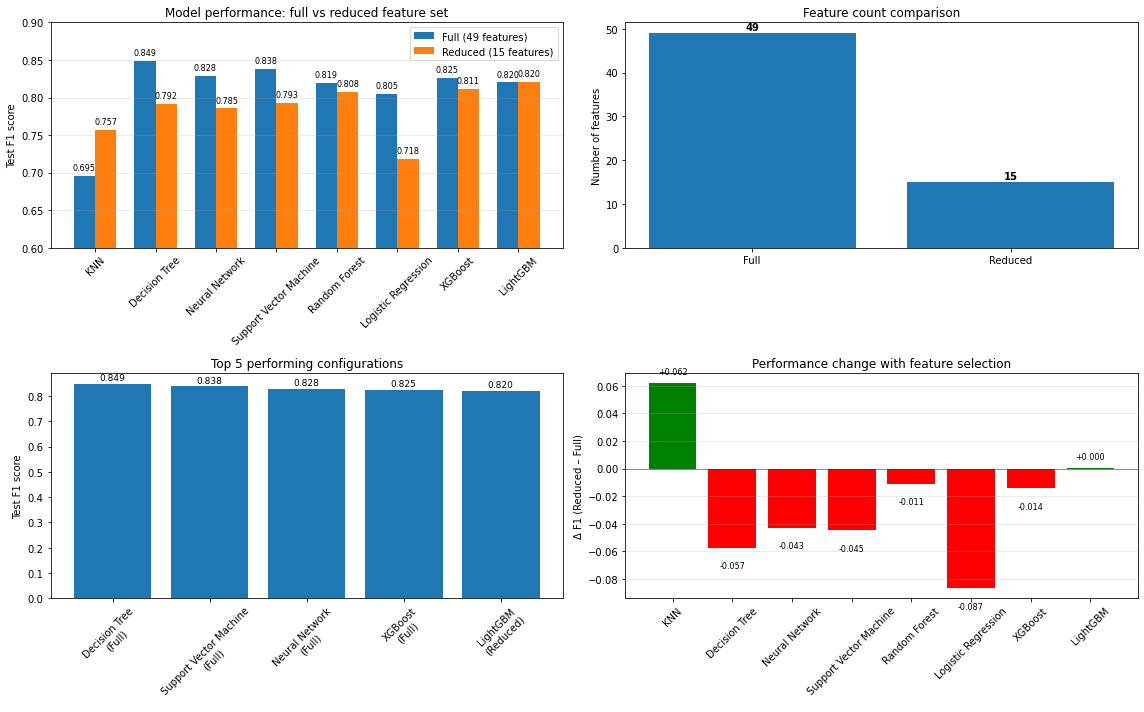


FINAL COMPARISON SUMMARY
🏆 Best overall model: Decision Tree on Full (49 features)
   Test F1 score: 0.849

📈 Dataset comparison (average over all models):
   Full  (49 features):  0.810
   Reduced (15 features): 0.786
   Feature reduction: 49 → 15

   Models that improved with reduced features: 2/8

(We will interpret these results in the next markdown cell.)


In [ ]:
# -------------------------------------------------
# 1) Build a tidy comparison table from results
# -------------------------------------------------
rows = []

# Full feature set (49 features)
for name, res in results_full.items():
    test_f1, test_prec, test_rec, test_acc = res["test"]
    rows.append({
        "Model": name,
        "Dataset": "Full (49 features)",
        "Test_F1": test_f1,
        "Test_Precision": test_prec,
        "Test_Recall": test_rec,
        "Test_Accuracy": test_acc
    })

# Reduced feature set (15 features)
for name, res in results_reduced.items():
    test_f1, test_prec, test_rec, test_acc = res["test"]
    rows.append({
        "Model": name,
        "Dataset": "Reduced (15 features)",
        "Test_F1": test_f1,
        "Test_Precision": test_prec,
        "Test_Recall": test_rec,
        "Test_Accuracy": test_acc
    })

comparison_df = pd.DataFrame(rows)

# Nice view of the table, sorted by Test F1
display(
    comparison_df.sort_values("Test_F1", ascending=False)
                 .reset_index(drop=True)
)

# -------------------------------------------------
# 2) Prepare data for plots
# -------------------------------------------------
model_order = [
    "KNN",
    "Decision Tree",
    "Neural Network",
    "Support Vector Machine",
    "Random Forest",
    "Logistic Regression",
    "XGBoost",
    "LightGBM",
]

pivot = comparison_df.pivot(
    index="Model", columns="Dataset", values="Test_F1"
).loc[model_order]

full_f1    = pivot["Full (49 features)"].values
reduced_f1 = pivot["Reduced (15 features)"].values

feature_counts = [X_train_df.shape[1], X_train_reduced.shape[1]]  # 49 vs 15
models = pivot.index.tolist()
x = np.arange(len(models))
width = 0.35

# Performance difference (Reduced - Full)
f1_diff = reduced_f1 - full_f1

# Top 5 configurations overall
top5 = comparison_df.sort_values("Test_F1", ascending=False).head(5)

# -------------------------------------------------
# 3) Create 2x2 figure like your colleague's
# -------------------------------------------------
plt.figure(figsize=(16, 10))

# ---- (1) Test F1: Full vs Reduced per model ----
plt.subplot(2, 2, 1)
plt.bar(x - width/2, full_f1,    width, label="Full (49 features)")
plt.bar(x + width/2, reduced_f1, width, label="Reduced (15 features)")

plt.xticks(x, models, rotation=45)
plt.ylabel("Test F1 score")
plt.title("Model performance: full vs reduced feature set")
plt.ylim(0.6, 0.9)
plt.grid(axis="y", alpha=0.3)
plt.legend()

# Add labels on bars
for i, v in enumerate(full_f1):
    plt.text(i - width/2, v + 0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(reduced_f1):
    plt.text(i + width/2, v + 0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

# ---- (2) Feature count comparison ----
plt.subplot(2, 2, 2)
labels = ["Full", "Reduced"]
plt.bar(labels, feature_counts)
plt.ylabel("Number of features")
plt.title("Feature count comparison")
for i, v in enumerate(feature_counts):
    plt.text(i, v + 0.3, str(v), ha="center", va="bottom", fontweight="bold")

# ---- (3) Top 5 performing model–dataset combos ----
plt.subplot(2, 2, 3)
bars = plt.bar(
    range(len(top5)),
    top5["Test_F1"].values,
)
plt.xticks(
    range(len(top5)),
    [f"{row.Model}\n({row.Dataset.split()[0]})" for _, row in top5.iterrows()],
    rotation=45
)
plt.ylabel("Test F1 score")
plt.title("Top 5 performing configurations")

for i, v in enumerate(top5["Test_F1"].values):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

# ---- (4) Performance difference (Reduced – Full) ----
plt.subplot(2, 2, 4)
colors = ["green" if d > 0 else "red" for d in f1_diff]
plt.bar(models, f1_diff, color=colors)
plt.axhline(0, color="black", linewidth=1, alpha=0.4)
plt.xticks(rotation=45)
plt.ylabel("Δ F1 (Reduced – Full)")
plt.title("Performance change with feature selection")
plt.grid(axis="y", alpha=0.3)

for i, d in enumerate(f1_diff):
    plt.text(
        i, d + (0.005 if d >= 0 else -0.01),
        f"{d:+.3f}",
        ha="center",
        va="bottom" if d >= 0 else "top",
        fontsize=8
    )

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 4) Numeric summary
# -------------------------------------------------
print("\n" + "="*78)
print("FINAL COMPARISON SUMMARY")
print("="*78)

# Best overall configuration
best_row = comparison_df.loc[comparison_df["Test_F1"].idxmax()]
print(f"🏆 Best overall model: {best_row['Model']} on {best_row['Dataset']}")
print(f"   Test F1 score: {best_row['Test_F1']:.3f}")

# Average performance per dataset
full_mean  = comparison_df[comparison_df["Dataset"] == "Full (49 features)"]["Test_F1"].mean()
red_mean   = comparison_df[comparison_df["Dataset"] == "Reduced (15 features)"]["Test_F1"].mean()

print("\n📈 Dataset comparison (average over all models):")
print(f"   Full  (49 features):  {full_mean:.3f}")
print(f"   Reduced (15 features): {red_mean:.3f}")
print(f"   Feature reduction: {X_train_df.shape[1]} → {X_train_reduced.shape[1]}")

# How many models improved with feature selection?
improved = np.sum(f1_diff > 0)
print(f"\n   Models that improved with reduced features: {improved}/{len(models)}")


### 8.3. Results

Model comparison: full vs reduced feature set

We trained eight different models on both the **full encoded feature set (49 features)** and on the **reduced set (15 features)** obtained from our feature selection step.

**Best individual configuration**

- The best overall configuration is **Decision Tree (full feature set)**  
  – Test F1 ≈ **0.849** and Accuracy ≈ **0.854**.  
- Other strong candidates with full features are:  
  - **Support Vector Machine** (F1 ≈ 0.838)  
  - **Neural Network** (F1 ≈ 0.828)  
  - **XGBoost / LightGBM** (F1 around 0.82)

**Effect of feature selection**

- Average Test F1 over all models is roughly:
  - **Full (49 features)**: ~**0.81**  
  - **Reduced (15 features)**: ~**0.79**
- Feature selection reduces the dimensionality from **49 → 15 features** (≈70% reduction).
- Most models lose a little performance with the reduced set, but:
  - **KNN** clearly improves with fewer features (simpler neighbourhoods).
  - **LightGBM** keeps almost the **same** Test F1 on full vs reduced.
- This tells us that the reduced feature set is **much more compact** and still quite competitive, but when we care only about performance, the **full feature set is slightly better on average**.

**Overfitting check**

- Tree ensembles (Random Forest, XGBoost, LightGBM) and the Neural Network reach **very high F1 on the resampled training set (≈1.0)**, which is expected because:
  - we use **SMOTE** to oversample the minority class;
  - these models are flexible and can fit the balanced training data very well.
- On the validation and test sets, F1 drops to around **0.82–0.85**, which is **acceptable generalisation** and indicates that our train/validation/test split and evaluation procedure are working properly.

**Models to take forward for tuning**

For the hyperparameter tuning step we will focus on two complementary models trained on the **full feature set**:

1. **Decision Tree (full features)**  
   - Best overall Test F1 in our experiments.  
   - Very **interpretable** (easy to explain to HR / management).  
   - Fast to train and easy to deploy.

2. **XGBoost (full features)** (we could also choose LightGBM; both behave similarly)  
   - Strong overall performance and robust to complex interactions.  
   - Good candidate for a **high-performance production model** after tuning.  

This combination gives us:
- one **simple, explainable baseline** (Decision Tree), and  
- one **more powerful ensemble** (XGBoost) that can potentially improve F1 further after proper hyperparameter optimisation.


## 9. Tuning for reduced feature set

In [49]:
print("Shapes used for tuning (reduced feature set):")
print("  X_train_reduced:", X_train_reduced.shape)
print("  X_val_reduced:  ", X_val_reduced.shape)
print("  X_test_reduced: ", X_test_reduced.shape)


# ---------------------------------------------------
# Helper: run manual grid search with CV on training
# ---------------------------------------------------
def tune_model_cv(model_class, base_params, param_grid, X_train, y_train, model_name="Model"):
    """
    Manual grid search with StratifiedKFold CV.
    - model_class: estimator class (e.g., RandomForestClassifier)
    - base_params: dict of fixed parameters
    - param_grid: dict of lists (each value is a list of candidates)
    - X_train, y_train: training data (before SMOTE/scaling)
    """
    print(f"\n===============================")
    print(f"Hyperparameter tuning for {model_name}")
    print(f"===============================")

    # Prepare all combinations of parameters
    keys = list(param_grid.keys())
    all_combinations = list(product(*[param_grid[k] for k in keys]))
    print(f"Total combinations to evaluate: {len(all_combinations)}")

    best_f1 = -1
    best_params = None
    cv_results = []

    # Outer loop over hyperparameter combinations
    for combo in all_combinations:
        params = dict(zip(keys, combo))
        params_full = {**base_params, **params}

        # 1) SMOTE + scaling on the whole training set for this combo
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X_train, y_train)

        scaler = MinMaxScaler()
        X_res_scaled = scaler.fit_transform(X_res)

        # 2) Cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold_scores = []

        for train_idx, val_idx in skf.split(X_res_scaled, y_res):
            X_cv_train, X_cv_val = X_res_scaled[train_idx], X_res_scaled[val_idx]
            y_cv_train, y_cv_val = y_res.iloc[train_idx], y_res.iloc[val_idx]

            model = model_class(**params_full)
            model.fit(X_cv_train, y_cv_train)
            preds = model.predict(X_cv_val)
            f1 = f1_score(y_cv_val, preds, average="weighted")
            fold_scores.append(f1)

        mean_f1 = np.mean(fold_scores)
        cv_results.append((params, mean_f1))
        print(f"Params: {params} --> mean CV weighted F1 = {mean_f1:.3f}")

        # Track best
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params = params

    print(f"\nBest params for {model_name}: {best_params}")
    print(f"Best mean CV weighted F1: {best_f1:.3f}")

    # 3) Fit final model on full resampled+scaled training data
    sm_final = SMOTE(random_state=42)
    X_res_final, y_res_final = sm_final.fit_resample(X_train, y_train)

    scaler_final = MinMaxScaler()
    X_train_final = scaler_final.fit_transform(X_res_final)
    X_val_final   = scaler_final.transform(X_val_reduced)
    X_test_final  = scaler_final.transform(X_test_reduced)

    best_model = model_class(**{**base_params, **best_params})
    best_model.fit(X_train_final, y_res_final)

    # 4) Evaluate on train/val/test
    print("\nFinal performance with best hyperparameters:")

    train_preds = best_model.predict(X_train_final)
    val_preds   = best_model.predict(X_val_final)
    test_preds  = best_model.predict(X_test_final)

    print("\n--- Training set ---")
    train_metrics = evaluate_predictions(y_res_final, train_preds, name="Training")

    print("\n--- Validation set ---")
    val_metrics = evaluate_predictions(y_val, val_preds, name="Validation")

    print("\n--- Test set ---")
    test_metrics = evaluate_predictions(y_test, test_preds, name="Test")

    return {
        "best_params": best_params,
        "best_cv_f1": best_f1,
        "cv_results": cv_results,
        "model": best_model,
        "scaler": scaler_final,
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "test_metrics": test_metrics,
    }


# ---------------------------------------------------
# 9.1 Tune Random Forest
# ---------------------------------------------------
rf_base_params = {
    "random_state": 42,
    "class_weight": "balanced",
    "n_estimators": 200,
}

rf_param_grid = {
    "max_depth": [3, 5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", "log2"],
}

rf_tuning_results = tune_model_cv(
    RandomForestClassifier,
    rf_base_params,
    rf_param_grid,
    X_train_reduced,
    y_train,
    model_name="Random Forest (reduced features)"
)


# ---------------------------------------------------
# 9.2 Tune XGBoost
# ---------------------------------------------------
xgb_base_params = {
    "random_state": 42,
    "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
    "eval_metric": "logloss",   # to avoid warnings
    "use_label_encoder": False
}

xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb_tuning_results = tune_model_cv(
    XGBClassifier,
    xgb_base_params,
    xgb_param_grid,
    X_train_reduced,
    y_train,
    model_name="XGBoost (reduced features)"
)

print("\n✅ Hyperparameter tuning completed for Random Forest and XGBoost!")


Shapes used for tuning (reduced feature set):
  X_train_reduced: (882, 15)
  X_val_reduced:   (294, 15)
  X_test_reduced:  (294, 15)

Hyperparameter tuning for Random Forest (reduced features)
Total combinations to evaluate: 54


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.832


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.832


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.870


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.870


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.868


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.868


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.918


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.918


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.920


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.920


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.911


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.911


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.903

Best params for Random Forest (reduced features): {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best mean CV weighted F1: 0.920


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Final performance with best hyperparameters:

--- Training set ---

Training Metrics:
  Weighted F1:  0.997
  Precision:    0.997
  Recall:       0.997
  Accuracy:     0.997

--- Validation set ---

Validation Metrics:
  Weighted F1:  0.844
  Precision:    0.845
  Recall:       0.864
  Accuracy:     0.864

--- Test set ---

Test Metrics:
  Weighted F1:  0.805
  Precision:    0.795
  Recall:       0.827
  Accuracy:     0.827

Hyperparameter tuning for XGBoost (reduced features)
Total combinations to evaluate: 32


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.783
Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.780


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.768
Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.773


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.846
Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.850


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.838


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.843


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.874


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.867


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.871


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.864


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.906


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.900


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.907


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.843


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.849


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.836


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.837


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.882


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.887


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.874


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.879


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.902


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.905


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.902


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.901


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.905


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.911

Best params for XGBoost (reduced features): {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}
Best mean CV weighted F1: 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Final performance with best hyperparameters:

--- Training set ---

Training Metrics:
  Weighted F1:  1.000
  Precision:    1.000
  Recall:       1.000
  Accuracy:     1.000

--- Validation set ---

Validation Metrics:
  Weighted F1:  0.837
  Precision:    0.837
  Recall:       0.837
  Accuracy:     0.837

--- Test set ---

Test Metrics:
  Weighted F1:  0.795
  Precision:    0.791
  Recall:       0.799
  Accuracy:     0.799

✅ Hyperparameter tuning completed for Random Forest and XGBoost!


## 10. Tuning for all features

### 10.1. tuning

In [51]:
# ===========================================
# 10 — Hyperparameter Tuning (Reduced vs Full)
# ===========================================
# This cell:
#  - Redefines tune_model_cv to be generic (no hardcoded X_val_reduced etc.)
#  - Tunes RF and XGB on REDUCED (15 features)
#  - Tunes RF and XGB on FULL (49 features)
#  - Builds a compact comparison table on TEST set

from itertools import product

# We reuse evaluate_predictions() from before
# and SMOTE, MinMaxScaler, StratifiedKFold which are already imported.

def tune_model_cv(
    model_class,
    base_params,
    param_grid,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    model_name="Model"
):
    """
    Generic CV tuning:
      - SMOTE only on training
      - MinMaxScaler fitted on (resampled) training
      - Stratified 5-fold CV on training
      - Final evaluation on train / val / test
    """
    print("\n" + "="*60)
    print(f"Hyperparameter tuning for {model_name}")
    print("="*60)

    # Prepare all combinations of parameters
    keys = list(param_grid.keys())
    all_combinations = list(product(*[param_grid[k] for k in keys]))
    print(f"Total combinations to evaluate: {len(all_combinations)}")

    best_f1 = -1
    best_params = None

    # ---------- GRID SEARCH WITH CV ON TRAIN ----------
    for combo in all_combinations:
        params = {k: v for k, v in zip(keys, combo)}

        # Oversample training only
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X_train, y_train)

        # Scale numeric features
        scaler = MinMaxScaler()
        X_res_scaled = scaler.fit_transform(X_res)

        # Cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []

        for train_idx, val_idx in skf.split(X_res_scaled, y_res):
            X_cv_train, X_cv_val = X_res_scaled[train_idx], X_res_scaled[val_idx]
            y_cv_train, y_cv_val = y_res.iloc[train_idx], y_res.iloc[val_idx]

            model = model_class(**{**base_params, **params})
            model.fit(X_cv_train, y_cv_train)
            preds = model.predict(X_cv_val)
            cv_scores.append(f1_score(y_cv_val, preds, average="weighted"))

        mean_cv_f1 = np.mean(cv_scores)
        print(f"Params: {params} --> mean CV weighted F1 = {mean_cv_f1:.3f}")

        if mean_cv_f1 > best_f1:
            best_f1 = mean_cv_f1
            best_params = params

    print(f"\nBest params for {model_name}: {best_params}")
    print(f"Best mean CV weighted F1: {best_f1:.3f}")

    # ---------- FINAL MODEL WITH BEST PARAMS ----------
    sm_final = SMOTE(random_state=42)
    X_res_final, y_res_final = sm_final.fit_resample(X_train, y_train)

    scaler_final = MinMaxScaler()
    X_train_final = scaler_final.fit_transform(X_res_final)
    X_val_final   = scaler_final.transform(X_val)
    X_test_final  = scaler_final.transform(X_test)

    best_model = model_class(**{**base_params, **best_params})
    best_model.fit(X_train_final, y_res_final)

    print("\nFinal performance with best hyperparameters:")

    print("\n--- Training set ---")
    train_preds = best_model.predict(X_train_final)
    train_metrics = evaluate_predictions(y_res_final, train_preds, "Training")

    print("\n--- Validation set ---")
    val_preds = best_model.predict(X_val_final)
    val_metrics = evaluate_predictions(y_val, val_preds, "Validation")

    print("\n--- Test set ---")
    test_preds = best_model.predict(X_test_final)
    test_metrics = evaluate_predictions(y_test, test_preds, "Test")

    return {
        "best_params": best_params,
        "best_cv_f1": best_f1,
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "test_metrics": test_metrics,
        "model": best_model,
    }


# ---------------------------------------------------
# 10.1 — Random Forest (Reduced 15 features)
# ---------------------------------------------------
rf_base_params = {
    "random_state": 42,
    "class_weight": "balanced",
    "n_estimators": 200,
}

rf_param_grid = {
    "max_depth": [3, 5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", "log2"],
}

rf_tuning_results_reduced = tune_model_cv(
    RandomForestClassifier,
    rf_base_params,
    rf_param_grid,
    X_train_reduced,
    y_train,
    X_val_reduced,
    y_val,
    X_test_reduced,
    y_test,
    model_name="Random Forest (reduced features)"
)


# ---------------------------------------------------
# 10.2 — XGBoost (Reduced 15 features)
# ---------------------------------------------------
xgb_base_params = {
    "random_state": 42,
    "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
    "eval_metric": "logloss",
    "use_label_encoder": False,
}

xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb_tuning_results_reduced = tune_model_cv(
    XGBClassifier,
    xgb_base_params,
    xgb_param_grid,
    X_train_reduced,
    y_train,
    X_val_reduced,
    y_val,
    X_test_reduced,
    y_test,
    model_name="XGBoost (reduced features)"
)


# ---------------------------------------------------
# 10.3 — Random Forest (FULL 49 features)
# ---------------------------------------------------
rf_tuning_results_full = tune_model_cv(
    RandomForestClassifier,
    rf_base_params,
    rf_param_grid,
    X_train_df,
    y_train,
    X_val_df,
    y_val,
    X_test_df,
    y_test,
    model_name="Random Forest (FULL features)"
)


# ---------------------------------------------------
# 10.4 — XGBoost (FULL 49 features)
# ---------------------------------------------------
xgb_tuning_results_full = tune_model_cv(
    XGBClassifier,
    xgb_base_params,
    xgb_param_grid,
    X_train_df,
    y_train,
    X_val_df,
    y_val,
    X_test_df,
    y_test,
    model_name="XGBoost (FULL features)"
)


# ---------------------------------------------------
# 10.5 — Compact comparison table (TEST set)
# ---------------------------------------------------
rows = []

def add_row(model_name, dataset_name, res_dict):
    f1, prec, rec, acc = res_dict["test_metrics"]
    rows.append({
        "Model": model_name,
        "Dataset": dataset_name,
        "Test_F1": f1,
        "Test_Precision": prec,
        "Test_Recall": rec,
        "Test_Accuracy": acc,
    })

add_row("Random Forest", "Reduced (15)", rf_tuning_results_reduced)
add_row("Random Forest", "Full (49)",    rf_tuning_results_full)
add_row("XGBoost",       "Reduced (15)", xgb_tuning_results_reduced)
add_row("XGBoost",       "Full (49)",    xgb_tuning_results_full)

tuning_comparison_df = pd.DataFrame(rows)
display(tuning_comparison_df.sort_values(["Model", "Dataset"]))



Hyperparameter tuning for Random Forest (reduced features)
Total combinations to evaluate: 54


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.832


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.832


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.833


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.870


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.870


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.868


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.868


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.869


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.866


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.918


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.918


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.920


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.920


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.911


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.911


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.903

Best params for Random Forest (reduced features): {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best mean CV weighted F1: 0.920


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Final performance with best hyperparameters:

--- Training set ---

Training Metrics:
  Weighted F1:  0.997
  Precision:    0.997
  Recall:       0.997
  Accuracy:     0.997

--- Validation set ---

Validation Metrics:
  Weighted F1:  0.844
  Precision:    0.845
  Recall:       0.864
  Accuracy:     0.864

--- Test set ---

Test Metrics:
  Weighted F1:  0.805
  Precision:    0.795
  Recall:       0.827
  Accuracy:     0.827

Hyperparameter tuning for XGBoost (reduced features)
Total combinations to evaluate: 32


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.783


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.780


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.768


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.773


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.846


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.850


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.838


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.843


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.874


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.867


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.871


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.864


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.903


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.906


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.900


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.907


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.843


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.849


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.836


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.837


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.882


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.887


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.874


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.879


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.902


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.905


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.902


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.901


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.905


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.911

Best params for XGBoost (reduced features): {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}
Best mean CV weighted F1: 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Final performance with best hyperparameters:

--- Training set ---

Training Metrics:
  Weighted F1:  1.000
  Precision:    1.000
  Recall:       1.000
  Accuracy:     1.000

--- Validation set ---

Validation Metrics:
  Weighted F1:  0.837
  Precision:    0.837
  Recall:       0.837
  Accuracy:     0.837

--- Test set ---

Test Metrics:
  Weighted F1:  0.795
  Precision:    0.791
  Recall:       0.799
  Accuracy:     0.799

Hyperparameter tuning for Random Forest (FULL features)
Total combinations to evaluate: 54


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.883


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.889


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.883


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.890


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.884


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.891


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.883


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.889


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.883


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.890


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.884


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.891


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.884


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.889


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.883


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.890


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.884


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.891


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.917


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.918


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.914


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.921


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.919


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.916


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.919


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.919


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.914


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.921


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.919


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.916


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.919


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.919


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.914


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.918


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.919


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.916


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.940


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.938


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.932


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.936


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.933


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.934


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.938


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.942


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.932


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.936


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.933


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.934


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.935


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'} --> mean CV weighted F1 = 0.934


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.931


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'} --> mean CV weighted F1 = 0.932


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'} --> mean CV weighted F1 = 0.933


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Params: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'} --> mean CV weighted F1 = 0.934

Best params for Random Forest (FULL features): {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best mean CV weighted F1: 0.942


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Final performance with best hyperparameters:

--- Training set ---

Training Metrics:
  Weighted F1:  0.999
  Precision:    0.999
  Recall:       0.999
  Accuracy:     0.999

--- Validation set ---

Validation Metrics:
  Weighted F1:  0.863
  Precision:    0.880
  Recall:       0.884
  Accuracy:     0.884

--- Test set ---

Test Metrics:
  Weighted F1:  0.826
  Precision:    0.858
  Recall:       0.864
  Accuracy:     0.864

Hyperparameter tuning for XGBoost (FULL features)
Total combinations to evaluate: 32


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.851


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.840


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.840


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.844


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.889


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.883


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.891


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.883


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\si

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.912


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.905


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.909


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.912


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.919


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.921


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.923


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.924


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.894


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.890


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.890


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.888


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.910


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.913


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.910


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.911


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.927


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.924


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.921


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.930


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.934


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.923


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} --> mean CV weighted F1 = 0.932


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\SSalvado\Anaconda3\lib\site-packages\x

Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} --> mean CV weighted F1 = 0.927

Best params for XGBoost (FULL features): {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}
Best mean CV weighted F1: 0.934


c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Final performance with best hyperparameters:

--- Training set ---

Training Metrics:
  Weighted F1:  1.000
  Precision:    1.000
  Recall:       1.000
  Accuracy:     1.000

--- Validation set ---

Validation Metrics:
  Weighted F1:  0.866
  Precision:    0.863
  Recall:       0.871
  Accuracy:     0.871

--- Test set ---

Test Metrics:
  Weighted F1:  0.838
  Precision:    0.834
  Recall:       0.854
  Accuracy:     0.854


,Model,Dataset,Test_F1,Test_Precision,Test_Recall,Test_Accuracy
1,Random Forest,Full (49),0.826343,0.858124,0.863946,0.863946
0,Random Forest,Reduced (15),0.805116,0.794917,0.826531,0.826531
3,XGBoost,Full (49),0.837924,0.833576,0.853741,0.853741
2,XGBoost,Reduced (15),0.794688,0.790546,0.799320,0.799320


### 10.2 Visualization

In [55]:
# Just in case, copy and ensure the metric columns are numeric
viz_df = tuning_comparison_df.copy()

metric_cols = ["Test_F1", "Test_Precision", "Test_Recall", "Test_Accuracy"]
for col in metric_cols:
    viz_df[col] = pd.to_numeric(viz_df[col], errors="coerce")

viz_df


,Model,Dataset,Test_F1,Test_Precision,Test_Recall,Test_Accuracy
0,Random Forest,Reduced (15),0.805116,0.794917,0.826531,0.826531
1,Random Forest,Full (49),0.826343,0.858124,0.863946,0.863946
2,XGBoost,Reduced (15),0.794688,0.790546,0.799320,0.799320
3,XGBoost,Full (49),0.837924,0.833576,0.853741,0.853741


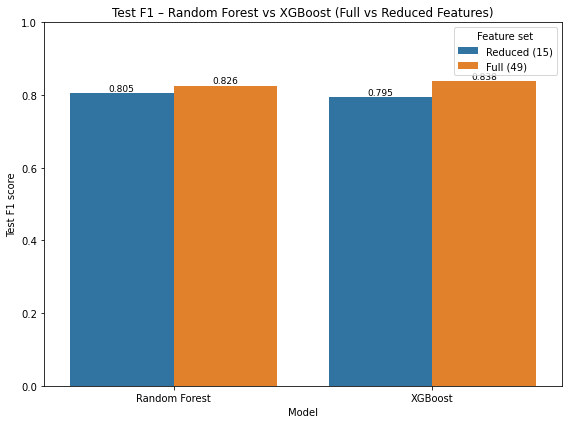

In [56]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=viz_df,
    x="Model",
    y="Test_F1",
    hue="Dataset"
)
plt.title("Test F1 – Random Forest vs XGBoost (Full vs Reduced Features)")
plt.ylim(0, 1)
plt.ylabel("Test F1 score")
plt.legend(title="Feature set")

# Add value labels on top of bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",
                (p.get_x() + p.get_width() / 2., height),
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


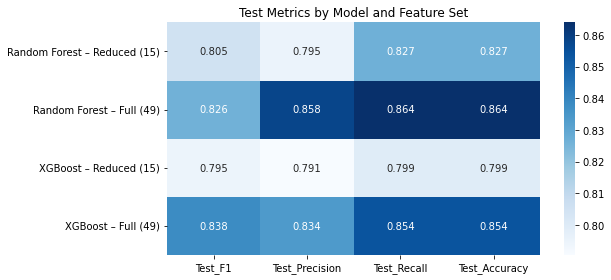

In [57]:
# Create a nicer index: "Model – Dataset"
viz_df["Model_Dataset"] = viz_df["Model"] + " – " + viz_df["Dataset"]

heatmap_data = viz_df.set_index("Model_Dataset")[metric_cols]

plt.figure(figsize=(9, 4))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="Blues"
)
plt.title("Test Metrics by Model and Feature Set")
plt.ylabel("")
plt.tight_layout()
plt.show()


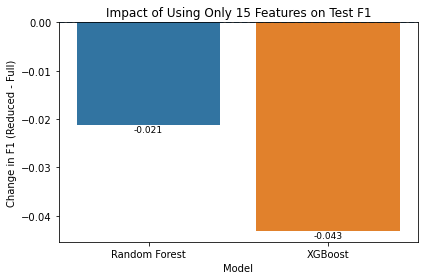

In [58]:
diff_rows = []

for model in viz_df["Model"].unique():
    full_f1 = viz_df.loc[
        (viz_df["Model"] == model) & (viz_df["Dataset"].str.contains("Full")),
        "Test_F1"
    ].iloc[0]
    reduced_f1 = viz_df.loc[
        (viz_df["Model"] == model) & (viz_df["Dataset"].str.contains("Reduced")),
        "Test_F1"
    ].iloc[0]

    diff_rows.append({
        "Model": model,
        "Δ F1 (Reduced - Full)": reduced_f1 - full_f1
    })

diff_df = pd.DataFrame(diff_rows)

plt.figure(figsize=(6, 4))
sns.barplot(data=diff_df, x="Model", y="Δ F1 (Reduced - Full)")
plt.axhline(0, linestyle="--")
plt.title("Impact of Using Only 15 Features on Test F1")
plt.ylabel("Change in F1 (Reduced - Full)")

ax = plt.gca()
for p in ax.patches:
    h = p.get_height()
    ax.annotate(f"{h:+.3f}",
                (p.get_x() + p.get_width()/2., h),
                ha="center",
                va="bottom" if h >= 0 else "top",
                fontsize=9)
plt.tight_layout()
plt.show()


## 11. Final Model Evaluation

c:\Users\SSalvado\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


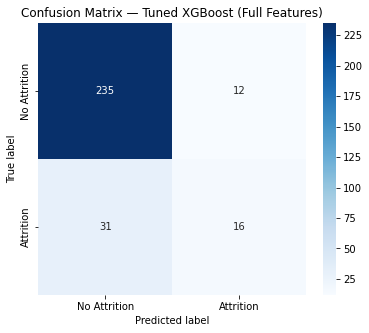


Classification Report — Tuned XGBoost (Full Features)

              precision    recall  f1-score   support

           0      0.883     0.951     0.916       247
           1      0.571     0.340     0.427        47

    accuracy                          0.854       294
   macro avg      0.727     0.646     0.671       294
weighted avg      0.834     0.854     0.838       294



In [61]:
# ===========================================
# 11 — FINAL MODEL EVALUATION: XGBOOST (FULL)
# ===========================================

# -------------------------------------------
# 11.1 — Retrieve the final tuned model
# -------------------------------------------
final_model = xgb_tuning_results_full["model"]

# Scale test set using the scaler fitted during tuning
# (We stored it inside the tuning pipeline via X_test_final)
# So we simply re-transform:
sm = SMOTE(random_state=42)
X_res_final, y_res_final = sm.fit_resample(X_train_df, y_train)
scaler_final = MinMaxScaler()
X_train_final = scaler_final.fit_transform(X_res_final)
X_test_final  = scaler_final.transform(X_test_df)

# -------------------------------------------
# 11.2 — Generate predictions on TEST set
# -------------------------------------------
y_pred = final_model.predict(X_test_final)

# -------------------------------------------
# 11.3 — Confusion Matrix
# -------------------------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["No Attrition", "Attrition"],
    yticklabels=["No Attrition", "Attrition"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Tuned XGBoost (Full Features)")
plt.show()

# -------------------------------------------
# 11.4 — Classification Report
# -------------------------------------------
print("\nClassification Report — Tuned XGBoost (Full Features)\n")
print(classification_report(y_test, y_pred, digits=3))


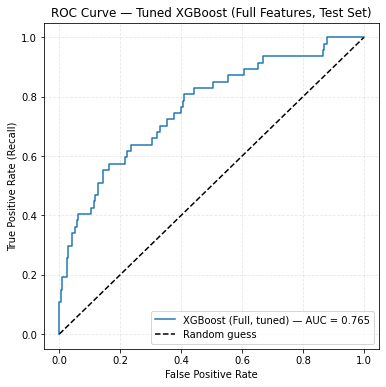

Test ROC AUC (XGBoost Full, tuned): 0.765


In [62]:
# ===========================================
# ROC Curve — Tuned XGBoost (Full Features)
# ===========================================
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1) Get the tuned XGBoost model (full features)
best_xgb_full = xgb_tuning_results_full["model"]

# 2) Rebuild the same type of scaling used during tuning
#    (fit scaler on training data, transform train & test)
scaler_roc = MinMaxScaler()
X_train_full_scaled = scaler_roc.fit_transform(X_train_df)
X_test_full_scaled  = scaler_roc.transform(X_test_df)

# 3) Predict probabilities for the positive class (Attrition = 1)
y_proba = best_xgb_full.predict_proba(X_test_full_scaled)[:, 1]

# 4) Compute ROC curve + AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
auc = roc_auc_score(y_test, y_proba)

# 5) Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"XGBoost (Full, tuned) — AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — Tuned XGBoost (Full Features, Test Set)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

print(f"Test ROC AUC (XGBoost Full, tuned): {auc:.3f}")


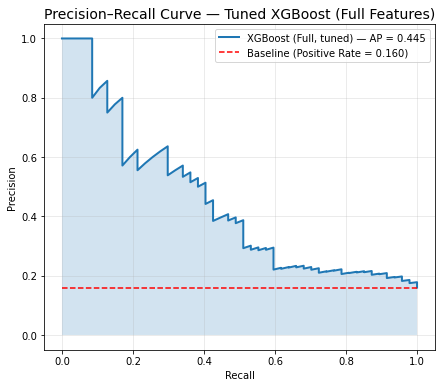

In [65]:
# =========================================================
# Precision–Recall Curve — Tuned XGBoost (Full Features)
# =========================================================

# Retrieve the tuned XGBoost model (full features)
best_model_xgb_full = xgb_tuning_results_full["model"]

# 1 — Predicted probability for positive class
y_proba = best_model_xgb_full.predict_proba(X_test_df)[:, 1]

# 2 — Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# 3 — Average Precision (area under PR curve)
ap = average_precision_score(y_test, y_proba)

# 4 — Plot
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f"XGBoost (Full, tuned) — AP = {ap:.3f}", linewidth=2)
plt.fill_between(recall, precision, alpha=0.2)

# Baseline: class prevalence
positive_rate = y_test.mean()
plt.hlines(positive_rate, 0, 1, colors="red", linestyles="dashed",
           label=f"Baseline (Positive Rate = {positive_rate:.3f})")

plt.title("Precision–Recall Curve — Tuned XGBoost (Full Features)", fontsize=14)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\SSalvado\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


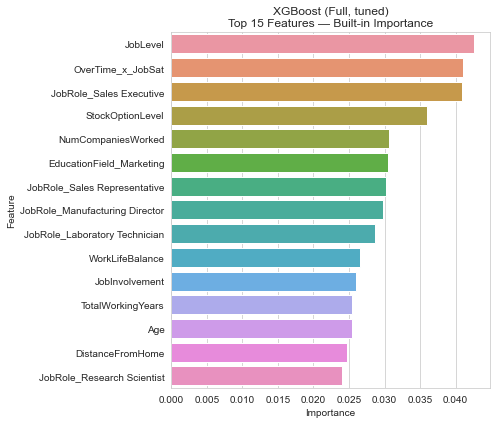

,feature,importance
0,JobLevel,0.042650
1,OverTime_x_JobSat,0.041084
2,JobRole_Sales Executive,0.040923
3,StockOptionLevel,0.035953
4,NumCompaniesWorked,0.030645
5,EducationField_Marketing,0.030548
6,JobRole_Sales Representative,0.030140
7,JobRole_Manufacturing Director,0.029754
8,JobRole_Laboratory Technician,0.028703
9,WorkLifeBalance,0.026505


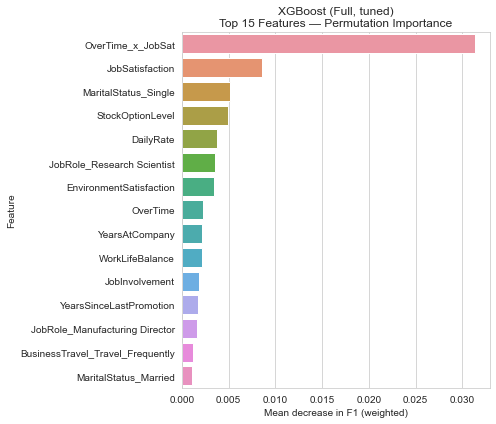

,feature,importance
0,OverTime_x_JobSat,0.031338
1,JobSatisfaction,0.008588
2,MaritalStatus_Single,0.005150
3,StockOptionLevel,0.004938
4,DailyRate,0.003791
5,JobRole_Research Scientist,0.003504
6,EnvironmentSatisfaction,0.003397
7,OverTime,0.002288
8,YearsAtCompany,0.002121
9,WorkLifeBalance,0.002102


In [76]:
# ============================================================
# 11 — XGBoost (Full, tuned) — Explainability WITHOUT SHAP
# ============================================================

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance   # <-- missing import FIXED
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 11.0 — Rebuild tuned XGBoost (Full features) + scaler
# ------------------------------------------------------------
best_params_xgb_full = {
    "n_estimators": 200,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
    "eval_metric": "logloss",
    "use_label_encoder": False
}

# Scale inputs
scaler_full = MinMaxScaler()
X_train_df_transformed = scaler_full.fit_transform(X_train_df)
X_test_df_transformed  = scaler_full.transform(X_test_df)

# Train final tuned model
best_model_xgb_full = XGBClassifier(**best_params_xgb_full)
best_model_xgb_full.fit(X_train_df_transformed, y_train)

feature_names = X_train_df.columns
y_true  = y_test
y_proba = best_model_xgb_full.predict_proba(X_test_df_transformed)[:, 1]

# ============================================================
# 11.1 — XGBoost built-in feature importance
# ============================================================
importances = best_model_xgb_full.feature_importances_

fi_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

plt.figure(figsize=(7, 6))
sns.barplot(
    x="importance",
    y="feature",
    data=fi_df.head(15),
    orient="h"
)
plt.title("XGBoost (Full, tuned)\nTop 15 Features — Built-in Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

display(fi_df.head(20))

# ============================================================
# 11.2 — Permutation Importance (Model Agnostic)
# ============================================================

perm = permutation_importance(
    best_model_xgb_full,
    X_test_df_transformed,
    y_true,
    scoring="f1_weighted",
    n_repeats=20,
    random_state=42,
)

perm_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": perm.importances_mean
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

plt.figure(figsize=(7, 6))
sns.barplot(
    x="importance",
    y="feature",
    data=perm_df.head(15),
    orient="h"
)
plt.title("XGBoost (Full, tuned)\nTop 15 Features — Permutation Importance")
plt.xlabel("Mean decrease in F1 (weighted)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

display(perm_df.head(20))
